In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/memo_3/memotion3/memotion3/train.csv')
train_df

,Unnamed: 0,image_url,humour,sarcastic,offensive,motivational,overall,ocr
0,0,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,not_offensive,not_motivational,neutral,Relationship status.\nSingle\nMarried\nIt's co...
1,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,slight,not_motivational,neutral,Bernie or REAGAN?\nBe informed. Compare them o...
2,2,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,not_offensive,not_motivational,positive,I HEAR SOMETHING\nBetter run a mile\nOMG RAJ?\...
3,3,https://preview.redd.it/iwcz3o2niix61.jpg?widt...,very_funny,twisted_meaning,not_offensive,not_motivational,positive,Redditors Visiting IG memepages\n*dies from cr...
4,4,https://encrypted-tbn0.gstatic.com/images?q=tb...,not_funny,not_sarcastic,very_offensive,not_motivational,negative,"Samajh nahi aaya Par sun ke acabo,\nBUDGET SPE..."
...,...,...,...,...,...,...,...,...
6995,6995,https://preview.redd.it/3c7iiijlg9d61.jpg?widt...,hilarious,general,slight,not_motivational,negative,$14 y/o nibbi*\n*16 y/o nibba*\n*20 y/o single...
6996,6996,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,very_twisted,hateful_offensive,not_motivational,negative,I DON'T HAVE A PROBLEM WITH\nIMMIGRATION\nIF W...
6997,6997,https://encrypted-tbn0.gstatic.com/images?q=tb...,hilarious,not_sarcastic,not_offensive,not_motivational,positive,"Como umbalin\nHey Alia,\nWhat is the\nOpposite..."
6998,6998,https://encrypted-tbn0.gstatic.com/images?q=tb...,hilarious,general,very_offensive,motivational,negative,baby kya kr rhe ho?\ntumhara favorite football...


In [ ]:
print(train_df['motivational'].value_counts())

motivational
not_motivational    6170
motivational         830
Name: count, dtype: int64


In [ ]:
train_df['motivational'] = train_df['motivational'].replace({
                                                            'not_motivational': 0,
                                                            'motivational': 1
                                                            })

In [ ]:
print(train_df['motivational'].value_counts())

motivational
0    6170
1     830
Name: count, dtype: int64


In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/val.csv')
val_df

,Unnamed: 0,image_url,humour,sarcastic,offensive,motivational,overall,ocr
0,0,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,twisted_meaning,not_offensive,not_motivational,neutral,RVCJ\nwww.EVCI.COM\nTum paas aaye yun muskuray...
1,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,general,slight,not_motivational,negative,"rukjao Maqbeol,\nbabuji ko tum nalt muaracay-\..."
2,2,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,slight,not_motivational,very_negative,champak appreciating Jetha\nfor following lock...
3,3,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,slight,not_motivational,negative,Noor Malik@ItsNoor 22h\nWhen you realize k\nNa...
4,4,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,general,slight,not_motivational,neutral,noop\nαποταθεωρία\nNehe: ita gis having 5 boyf...
...,...,...,...,...,...,...,...,...
1494,1495,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,twisted_meaning,not_offensive,not_motivational,neutral,"CHALATA HOON MAIN WAGONR\nABKI BAAR, MODI SARK..."
1495,1496,https://simg-memechat.s3.ap-south-1.amazonaws....,funny,general,not_offensive,not_motivational,neutral,*Tourist visiting\nAfghanistan\n*Terrorist wel...
1496,1497,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,slight,not_motivational,negative,Pic 1: Lockdown\nkhatam ho gya.. Ab\nPani-Puri...
1497,1498,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,not_offensive,not_motivational,positive,When you're from UP/Bihar\nand select English ...


In [ ]:
val_df['motivational'] = val_df['motivational'].replace({
                                                            'not_motivational': 0,
                                                            'motivational': 1
                                                            })

In [ ]:
print(val_df['motivational'].value_counts())

motivational
0    1456
1      43
Name: count, dtype: int64


In [ ]:
!pip install text_hammer

In [ ]:
import text_hammer as th

In [ ]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df, col_name):
  column = col_name
  df[column] = df[column].progress_apply(lambda x:str(x).lower())
  df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're -> you are; we'll be -> we will be
  df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))

  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))

  return df

CPU times: user 754 µs, sys: 0 ns, total: 754 µs
Wall time: 761 µs


In [ ]:
train_dataset = text_preprocessing(train_df, 'ocr')
val_dataset = text_preprocessing(val_df, 'ocr')

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

In [ ]:
class MemeDataset(Dataset):
    def __init__(self, images, captions, sentiments, tokenizer, image_transforms, image_dir):
        self.images = images
        self.captions = captions
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.image_dir, image_name)
        caption = self.captions[idx]
        sentiment = self.sentiments[idx]

        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)  # Create a blank image

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.image_transforms(image=image)['image']
        image = torch.tensor(image).permute(2, 0, 1).float()

        # Ensure caption is a string
        if not isinstance(caption, str):
            caption = str(caption)

        if isinstance(caption, list):
            caption = ' '.join(caption)

        if not caption:
            caption = "empty caption"

        # Encode caption
        encoded_caption = self.tokenizer([caption], return_tensors="pt", padding='max_length', truncation=True, max_length=77)
        input_ids = encoded_caption['input_ids'].squeeze()
        attention_mask = encoded_caption['attention_mask'].squeeze()

        sentiment_class = torch.tensor(sentiment)

        return {'image': image, 'input_ids': input_ids, 'attention_mask': attention_mask, 'sentiment': sentiment_class}

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

# Custom Channel Attention module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1, padding=0)
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1, padding=0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute average and maximum across spatial dimensions separately
        avg_out = torch.mean(x, dim=(2, 3), keepdim=True)
        max_out = torch.max(x, dim=2, keepdim=True)[0]
        max_out = torch.max(max_out, dim=3, keepdim=True)[0]

        avg_out = self.fc2(self.relu(self.fc1(avg_out)))
        max_out = self.fc2(self.relu(self.fc1(max_out)))
        return self.sigmoid(avg_out + max_out)


# Define custom model with CLIP and dense layers
class CustomCLIPModel(nn.Module):
    def __init__(self, clip_model):
        super(CustomCLIPModel, self).__init__()
        self.clip_model = clip_model

        # Determine the number of channels from the clip_model
        self.num_channels = 512  # Example: Replace with the actual number of channels from clip_model

        # Attention modules
        self.spatial_attention = SpatialAttention()
        self.channel_attention = ChannelAttention(in_planes=self.num_channels)  # Update to match actual number of channels

        self.fc1 = nn.Linear(self.num_channels + 512, 512)  # Adjusted input dimension
        self.dropout1 = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 2)
        self.gelu = nn.GELU()

    def forward(self, image, input_ids, attention_mask):
        text_features = self.clip_model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        image_features = self.clip_model.get_image_features(pixel_values=image)

        # Ensure image_features have the correct shape (batch_size, num_channels, height, width)
        if len(image_features.shape) == 2:
            image_features = image_features.unsqueeze(-1).unsqueeze(-1)

        # Apply spatial and channel attention
        spatial_att = self.spatial_attention(image_features)
        channel_att = self.channel_attention(image_features)

        image_features = image_features * spatial_att * channel_att

        # Flatten the image features or perform adaptive pooling
        image_features = torch.nn.functional.adaptive_avg_pool2d(image_features, (1, 1)).squeeze(-1).squeeze(-1)

        # Normalize features
        image_features = torch.nn.functional.normalize(image_features, dim=1)
        text_features = torch.nn.functional.normalize(text_features, dim=1)

        # Concatenate the text and image features
        combined_features = torch.cat((text_features, image_features), dim=1)

        x = self.fc1(combined_features)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.gelu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.gelu(x)
        x = self.dropout3(x)
        logits = self.fc4(x)

        return logits, image_features, text_features

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self, logits, labels):
        ce_loss = self.cross_entropy_loss(logits, labels)
        return ce_loss


def train_epoch(model, train_loader, optimizer, device, criterion):
    model.train()
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm_object:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        optimizer.zero_grad()
        logits, image_features, text_features = model(images, input_ids, attention_mask)
        loss = criterion(logits, sentiments)
        loss.backward()
        optimizer.step()

        count = images.size(0)
        loss_meter.update(loss.item(), count)

        preds = logits.argmax(dim=1)
        correct_predictions += (preds == sentiments).sum().item()
        total_predictions += sentiments.size(0)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    accuracy = correct_predictions / total_predictions
    return loss_meter, accuracy


def evaluate(model, data_loader, device, criterion):
    model.eval()
    predictions, true_labels = [], []
    loss_meter = AvgMeter()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)

            logits, image_features, text_features = model(images, input_ids, attention_mask)
            loss = criterion(logits, sentiments)

            loss_meter.update(loss.item(), len(images))

            preds = logits.argmax(dim=1)
            correct_predictions += (preds == sentiments).sum().item()
            total_predictions += sentiments.size(0)

            true = sentiments.cpu().numpy()
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(true)

    accuracy = correct_predictions / total_predictions
    return predictions, true_labels, loss_meter.avg, accuracy

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


train_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(p=0.3),  # Added augmentation
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

model = CustomCLIPModel(clip_model)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


train_image_dir = '/content/drive/MyDrive/Memotion3/drive-download-20240716T190908Z-001/trainImages'
val_image_dir = '/content/drive/MyDrive/Memotion3/drive-download-20240716T190908Z-001/valImages'

train_dataset = MemeDataset(
    images=train_dataset['image_url'].tolist(),
    captions=train_dataset['ocr'].tolist(),
    sentiments=train_dataset['motivational'].tolist(),
    tokenizer=processor.tokenizer,
    image_transforms=train_image_transforms,
    image_dir=train_image_dir
)

val_dataset = MemeDataset(
    images=val_dataset['image_url'].tolist(),
    captions=val_dataset['ocr'].tolist(),
    sentiments=val_dataset['motivational'].tolist(),
    tokenizer=processor.tokenizer,
    image_transforms=val_image_transforms,
    image_dir=val_image_dir
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay = 1e-3)
num_epochs = 8


scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)

# Loss functions
criterion = CustomLoss()

BEST_MODEL_PATH = 'best_model.pth'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, 'cuda' if torch.cuda.is_available() else 'cpu', criterion)
    val_predictions, val_true_labels, val_loss, val_accuracy = evaluate(model, val_loader, 'cuda' if torch.cuda.is_available() else 'cpu', criterion)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), BEST_MODEL_PATH)

    train_losses.append(train_loss.avg)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss.avg}, Train Accuracy: {train_accuracy}")
    print(f"Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

    scheduler.step()

model.load_state_dict(torch.load(BEST_MODEL_PATH))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1/8


  0%|          | 0/219 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 219/219 [02:03<00:00,  1.78it/s, lr=1e-5, train_loss=0.746]


Train Loss: 0.7458976285798209, Train Accuracy: 0.5067142857142857
Val Loss: 0.736986603833899, Val Accuracy: 0.37024683122081387
Epoch 2/8


100%|██████████| 219/219 [02:04<00:00,  1.77it/s, lr=9.99e-6, train_loss=0.697]


Train Loss: 0.6973898757525853, Train Accuracy: 0.5534285714285714
Val Loss: 0.6192097366054985, Val Accuracy: 0.7838559039359573
Epoch 3/8


100%|██████████| 219/219 [02:04<00:00,  1.76it/s, lr=9.99e-6, train_loss=0.644]


Train Loss: 0.6436662737301417, Train Accuracy: 0.6314285714285715
Val Loss: 0.6388039359098439, Val Accuracy: 0.7658438959306204
Epoch 4/8


100%|██████████| 219/219 [02:03<00:00,  1.77it/s, lr=9.98e-6, train_loss=0.6]


Train Loss: 0.6001152398926871, Train Accuracy: 0.6964285714285714
Val Loss: 0.6615781298154509, Val Accuracy: 0.6424282855236825
Epoch 5/8


100%|██████████| 219/219 [02:03<00:00,  1.77it/s, lr=9.98e-6, train_loss=0.565]


Train Loss: 0.5647914441653661, Train Accuracy: 0.7335714285714285
Val Loss: 0.6507288858125494, Val Accuracy: 0.6524349566377585
Epoch 6/8


100%|██████████| 219/219 [02:03<00:00,  1.77it/s, lr=9.97e-6, train_loss=0.516]


Train Loss: 0.5157272445474352, Train Accuracy: 0.782
Val Loss: 0.48013935556723486, Val Accuracy: 0.9159439626417611
Epoch 7/8


100%|██████████| 219/219 [02:03<00:00,  1.77it/s, lr=9.97e-6, train_loss=0.475]


Train Loss: 0.47486281091826305, Train Accuracy: 0.8075714285714286
Val Loss: 0.6039573030920328, Val Accuracy: 0.7358238825883923
Epoch 8/8


100%|██████████| 219/219 [02:04<00:00,  1.76it/s, lr=9.96e-6, train_loss=0.419]


Train Loss: 0.41850567167145863, Train Accuracy: 0.8577142857142858
Val Loss: 0.6061406287453507, Val Accuracy: 0.7591727818545697


<All keys matched successfully>

In [ ]:
from sklearn.metrics import f1_score, classification_report

val_predictions, val_true_labels, val_loss, val_accuracy = evaluate(model, val_loader,  'cuda' if torch.cuda.is_available() else 'cpu', criterion)

f1_weighted = f1_score(val_true_labels, val_predictions, average='weighted')
f1_macro = f1_score(val_true_labels, val_predictions, average='macro')
class_report = classification_report(val_true_labels, val_predictions)

print(f'Best Validation Accuracy: {best_val_accuracy}')
print(f'F1 Weighted: {f1_weighted:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'Classification Report:\n{class_report}')

Best Validation Accuracy: 0.9159439626417611
F1 Weighted: 0.9310
F1 Macro: 0.5215
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1456
           1       0.06      0.14      0.09        43

    accuracy                           0.92      1499
   macro avg       0.52      0.54      0.52      1499
weighted avg       0.95      0.92      0.93      1499



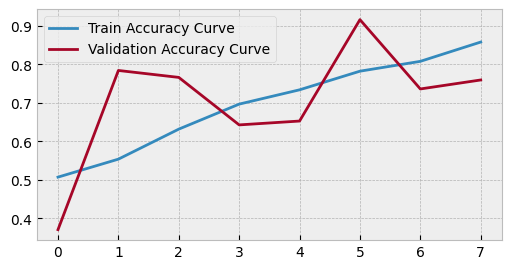

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(6,3))
plt.plot(train_accuracies, label='Train Accuracy Curve')
plt.plot(val_accuracies, label='Validation Accuracy Curve')
plt.legend()
plt.show()

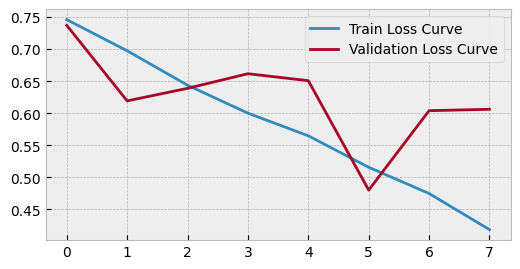

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(train_losses, label='Train Loss Curve')
plt.plot(val_losses, label='Validation Loss Curve')
plt.legend()
plt.show()

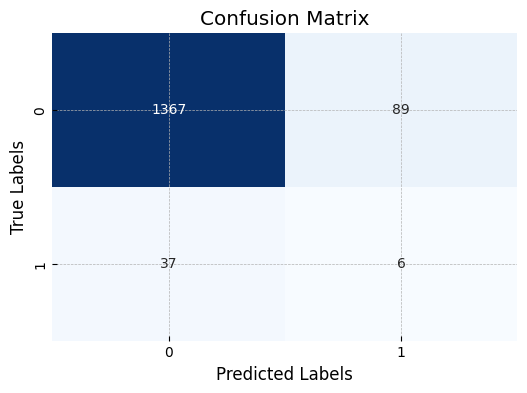

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(val_true_labels, val_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()